In [2]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
STORM_CLUSTS_OUT_PATH = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"

In [4]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"
df = pd.read_csv(IN_PATH, sep="\t")

df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=["date"])


#only keep data 
#first day of local coverage in our data, 4/1
firstLocDate = min(df.loc[df["national"] == False, "date"])

df = df[df["date"] > firstLocDate]
len(df)


<ipython-input-4-b658fbf83435>:2: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(IN_PATH, sep="\t")


4222409

In [5]:
CLUST_PIPE = "20000_90"

print(f"{df.dropna(subset=[CLUST_PIPE]).shape} articles didn't make it into an entity grouping") 

(1375105, 50) articles didn't make it into an entity grouping


In [6]:
#group clustered articles into rows 
longClusts = df[[CLUST_PIPE,"date"]].groupby(CLUST_PIPE).agg(list)

In [7]:
def numDays(inList): 
    return (max(inList) - min(inList)) / timedelta(hours=24)

#get cluster duration and size 
longClusts["clustLength"] = longClusts["date"].apply(numDays)
longClusts["numStories"] = longClusts["date"].apply(len)

In [8]:
#remove shorter stories 
longClusts = longClusts[(longClusts["clustLength"] > 5)].reset_index()

#take the long clusters and keep those rows in the long form article-per-row dataframe
longClusts = df[df[CLUST_PIPE].isin(longClusts[CLUST_PIPE].unique())]

In [9]:
print(f"{len(longClusts)} articles in clusters over 5 days") 
print(f"{len(longClusts[CLUST_PIPE].unique())} clusters over 5 days")
#we have 4 million articles that are in clusters over 5 days? doesn't quite seem right... 

117935 articles in clusters over 5 days
10475 clusters over 5 days


In [10]:
#now we start time-series part 
dateDf = longClusts[["source", "date", CLUST_PIPE]].sort_values("date")
dateDf["count"] = 1

In [11]:
dateDf.head()

,source,date,20000_90,count
345156,businessinsider,2020-04-02,11898.0,1
349057,sanmarcosdailyrecord,2020-04-02,172648.0,1
349080,cbsnews,2020-04-02,11898.0,1
349313,thedailycaller,2020-04-02,11898.0,1
349449,npr,2020-04-02,11898.0,1


In [12]:
df["count"] = 1

In [13]:
#within each outlet, get the 3 day rolling window of coverage 
timeRolling = df[["source", "date", "count"]].groupby(by=["source", "date"]).agg(sum).reset_index()

In [14]:
timeRolling = timeRolling.groupby("source").rolling("3D", on="date").sum() #.rolling("3D", on="date").sum()

In [15]:
timeRolling = timeRolling.reset_index().drop(columns=["level_1"])

In [206]:
#quick sanity check - shows that we don't have duplicate days 
print(len(timeRolling))
print(len(df.drop_duplicates(subset=["source", "date"])))

285585
285585


In [16]:
#within each outlet and cluster, get the three day rolling window of coverage 
timeRollingClust = dateDf.groupby(["source", CLUST_PIPE, "date"]).sum()\
.reset_index().groupby(["source", CLUST_PIPE]).rolling("3D", on="date").sum()

timeRollingClust = timeRollingClust.reset_index().drop(columns=["level_2"])

In [17]:
#same sanity check as above 
print(len(timeRollingClust))
print(len(timeRollingClust.drop_duplicates(subset=["source", CLUST_PIPE, "date"])))

109086
109086


Text(0.5, 1.0, '# number of articles in our 3 day rolling windows at outlet level')

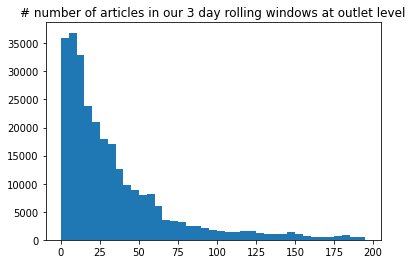

In [18]:
plt.hist(timeRolling["count"], bins=np.arange(0, 200, 5))
plt.title("# number of articles in our 3 day rolling windows at outlet level")

Text(0.5, 1.0, '# number of articles in our 3 day rolling windows at outlet,cluster level')

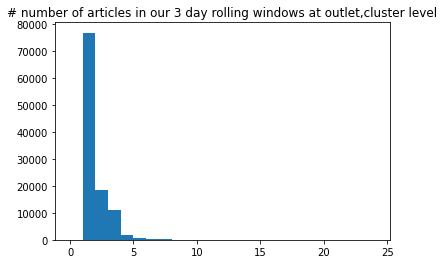

In [154]:
plt.hist(timeRollingClust["count"], bins=np.arange(0, 25, 1))
plt.title("# number of articles in our 3 day rolling windows at outlet,cluster level")
#interpretation: for most stories, outlets report a very small amount on that story in a 3 day window 

In [19]:
timeRollingClust.head()

,source,20000_90,date,count
0,21stcenturywire,836.0,2021-02-23,1.0
1,21stcenturywire,959.0,2021-03-30,1.0
2,21stcenturywire,2457.0,2021-11-13,1.0
3,21stcenturywire,3075.0,2020-07-11,1.0
4,21stcenturywire,3216.0,2020-08-12,1.0


In [99]:
#now we have the 3 day windows where we get total coverage and coverage for each cluster 
stormDf = pd.merge(timeRolling, timeRollingClust.rename(columns={"count":"clustCount"}), on=["source", "date"])

stormDf["reportingPercent"] = (stormDf["clustCount"] / stormDf["count"]) * 100

In [100]:
#sort storm df so we get the largest three day window for an outlet,cluster appearing first
stormDf = stormDf.sort_values(["source", CLUST_PIPE, "reportingPercent"], ascending=False)
stormDf = stormDf.drop_duplicates(["source", CLUST_PIPE], keep="first")

<Axes: xlabel='count', ylabel='Proportion'>

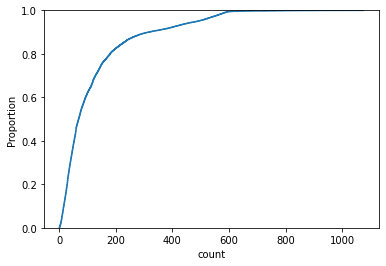

In [101]:
#example interpretation: 80% of 3-day periods have 200 or less articles in them 
sns.ecdfplot(x="count", data=stormDf)

In [102]:
stormDf = stormDf[stormDf["count"] >= 40]

<Axes: xlabel='reportingPercent', ylabel='Density'>

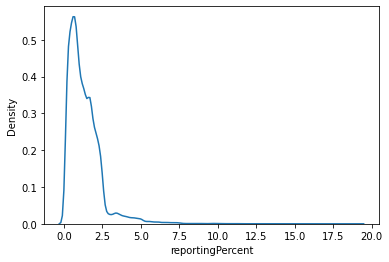

In [103]:
sns.kdeplot(x="reportingPercent", data=stormDf)

In [1]:
#is there an inflection point here maybe??? 
sns.ecdfplot(x="reportingPercent", data=stormDf)
plt.title("Empirical CDF: Coverage Dedicated to Event-Clusters")
plt.xlabel("% Dedicated to Event Cluster")
plt.ylabel("Proportion of 3-Day Windows")

NameError: name 'sns' is not defined

In [162]:
#the telegraph reporting on black friday and cyber monday 
#test = df.loc[(df[CLUST_PIPE] == 5130.0) & (df["source"] == "drudgereport"), ["title", "content", "source", "date"]]

#sns.lineplot(x="date",y="source", data=test[["date", "source"]].groupby("date").agg(len).reset_index())

#epoch times hurricane Ida 
#test = df.loc[(df[CLUST_PIPE] == 8716.0) & (df["source"] == "theepochtimes"), ["title", "content", "source", "date"]]

In [105]:
# so let's say that the cutoff is around 10 percent 
stormDf["isStorm"] = stormDf["reportingPercent"] >= 3

In [132]:
stormDf.head()

,source,date,count,20000_90,clustCount,reportingPercent,isStorm
108949,zerohedge,2021-10-06,138.0,398347.0,1.0,0.724638,False
108807,zerohedge,2021-07-09,145.0,389928.0,1.0,0.689655,False
108945,zerohedge,2021-10-04,118.0,382823.0,1.0,0.847458,False
108926,zerohedge,2021-09-21,125.0,360034.0,1.0,0.800000,False
108801,zerohedge,2021-07-03,134.0,356022.0,1.0,0.746269,False


In [161]:
storyStormDf = stormDf[[CLUST_PIPE,"isStorm", "source"]].groupby(CLUST_PIPE).agg({"isStorm":[np.mean, sum,list], "source":list}) #.rename(columns={"reportingPercent":"outletStormPercent"})

In [162]:
storyStormDf.columns = storyStormDf.columns.droplevel()
storyStormDf = storyStormDf.reset_index()

In [165]:
storyStormDf.head()

,20000_90,mean,sum,list,list
0,53.0,0.142857,1,"[False, False, False, False, False, True, False]","[theindependent, stillnessinthestorm, slate, r..."
1,102.0,0.105263,4,"[False, False, False, False, True, False, Fals...","[whatreallyhappened, westernjournal, waterbury..."
2,103.0,0.000000,0,"[False, False]","[thetennesseestar, inquisitr]"
3,182.0,0.000000,0,"[False, False, False, False, False, False]","[therussophileorg, thehuffingtonpost, thedaily..."
4,183.0,0.000000,0,"[False, False, False, False, False]","[usnews, thekennebecjournal, charlotteobserver..."


In [166]:
storyStormDf.columns = ["20000_90", "average_reporting_percent", "num_outlets_over_cutoff", "isStorm", "source"]

In [167]:
def getStormOutlets(inRow): 
    outlist = []
    for i, isStorm in enumerate(inRow["isStorm"]): 
        if isStorm: 
            outlist.append(inRow["source"][i])
    return outlist 

storyStormDf["stormSource"] = storyStormDf.apply(getStormOutlets, axis=1)

In [168]:
storyStormDf = storyStormDf.drop(columns=["isStorm", "source"])

In [169]:
#when we have at least three outlets on board 
stormClusts = list(storyStormDf.loc[storyStormDf["num_outlets_over_cutoff"] >= 5, CLUST_PIPE])

In [170]:
#112 storm clusters
len(stormClusts)

98

In [171]:
import random
stormSample = random.sample(stormClusts, 11)
stormSample

[10636.0,
 28369.0,
 5965.0,
 3156.0,
 39037.0,
 5676.0,
 21934.0,
 28064.0,
 3459.0,
 6781.0,
 16790.0]

In [88]:
#hasFloyd = df[(df[CLUST_PIPE].isin(stormClusts)) & (df["content"].str.contains("George Floyd"))]

In [89]:
"""
It seems like right now the storms are either too mixed, about the same general them but not really the same event, 
or it's debatable. 
"""
#with .9 cutoff: 
#1095.0: Hurricane Ida 
#5180.0: Daunte Wright shooting 
#78363.0: Connor McGregor fights Dustin Poirier. ERROR Both fights from 2021 are included 
#1697.0: Tom Moore raises money for NHS (U.K. story)
#7784.0: Liz Cheny ouseted from house leadership and is replaced by stefanik 
#8075.0: Wayne county canvassers not certifying Michigan election results
#1924.0: Prince Philip's funeral 
#7734.0: Marjorie Taylor Greene stripped of committee assignments 
#78393.0: Anthony Joshua vs. Kubrat Pulev UFC fight 
#1068.0: Tropical Storm Elsa 
#17408.0: Trump tries to keep records from January 6 committe 
#4770.0: Amazon and Apple remove Parler 

"\nIt seems like right now the storms are either too mixed, about the same general them but not really the same event, \nor it's debatable. \n"

In [172]:
len(stormArticles)

236

In [173]:
stormArticles = df[df[CLUST_PIPE] ==  2965.0]
#[item[:300] for item in list(stormArticles.sort_values("date").sample(30)["content"])]

for i, row in stormArticles.sample(10).sort_values("date").iterrows(): 
    print(row["title"])
    print(row["date"])

White House Tells Bolton His Book Still Contains Classified Information
2020-06-10 00:00:00
In new book, Bolton alleges Trump committed ‘Ukraine-like transgressions’ in other foreign policy decisions
2020-06-12 00:00:00
John Bolton Braces For Lawsuit From Trump Administration Over Unredacted Tell-All Book Release
2020-06-15 00:00:00
Trump: Former adviser Bolton faces charges if book released
2020-06-16 00:00:00
John Bolton: Trump administration sues to block book
2020-06-16 00:00:00
Trump Admin Sues Bolton To Block Book Publication
2020-06-17 00:00:00
Trump administration sues to delay release of Bolton book
2020-06-17 00:00:00
Justice Department sues President Trump’s former national security adviser
2020-06-17 00:00:00
Donald Trump accuses John Bolton of &apos;breaking the law&apos; over explosive White House memoir
2020-06-18 00:00:00
Judge: John Bolton can publish book despite efforts to block it
2020-06-20 00:00:00


In [174]:
storyStormDf[CLUST_PIPE + "_storm"] = True

In [176]:
storyStormDf = storyStormDf.rename(columns={"stormSource":CLUST_PIPE + "_storm_source", "average_reporting_percent":CLUST_PIPE + "_average_pct", "num_outlets_over_cutoff":CLUST_PIPE + "_num_over_cutoff"})

In [178]:
outDf = pd.merge(df[["key", CLUST_PIPE]], storyStormDf[storyStormDf[CLUST_PIPE + "_num_over_cutoff"] >= 5], on=CLUST_PIPE, how="right")

In [179]:
outDf[CLUST_PIPE].value_counts()

20000_90
8088.0      1378
533.0       1026
608.0        737
6876.0       622
4708.0       525
            ... 
19801.0       57
234960.0      57
111378.0      54
130664.0      52
94487.0       51
Name: count, Length: 98, dtype: int64

In [180]:
outDf.head()

,key,20000_90,20000_90_average_pct,20000_90_num_over_cutoff,20000_90_storm_source,20000_90_storm
0,2578047,359.0,0.25,11,"[thetribunechronicle, thelowellsun, startribun...",True
1,2858153,359.0,0.25,11,"[thetribunechronicle, thelowellsun, startribun...",True
2,3157398,359.0,0.25,11,"[thetribunechronicle, thelowellsun, startribun...",True
3,2890987,359.0,0.25,11,"[thetribunechronicle, thelowellsun, startribun...",True
4,2532064,359.0,0.25,11,"[thetribunechronicle, thelowellsun, startribun...",True


In [182]:
#outDf contains all articles that are a part of storms 
outDf.to_csv(STORM_CLUSTS_OUT_PATH, sep="\t")